In [1]:
#Libraries

%matplotlib inline

import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import keras.utils as image
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D,MaxPooling2D, Flatten, Dropout, BatchNormalization, MaxPool2D
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam, SGD
from keras.metrics import binary_crossentropy
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
import itertools
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras import regularizers



In [5]:
# loading data

data = glob.glob('C:/Users/sk22724/Downloads/project/data/IDC_regular_ps50_idx5/**/*.png', recursive = True)

In [6]:
for imgname in data[:3]:
    print(imgname)

C:/Users/sk22724/Downloads/project/data/IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1001_class0.png
C:/Users/sk22724/Downloads/project/data/IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1051_class0.png
C:/Users/sk22724/Downloads/project/data/IDC_regular_ps50_idx5\10253\0\10253_idx5_x1001_y1101_class0.png


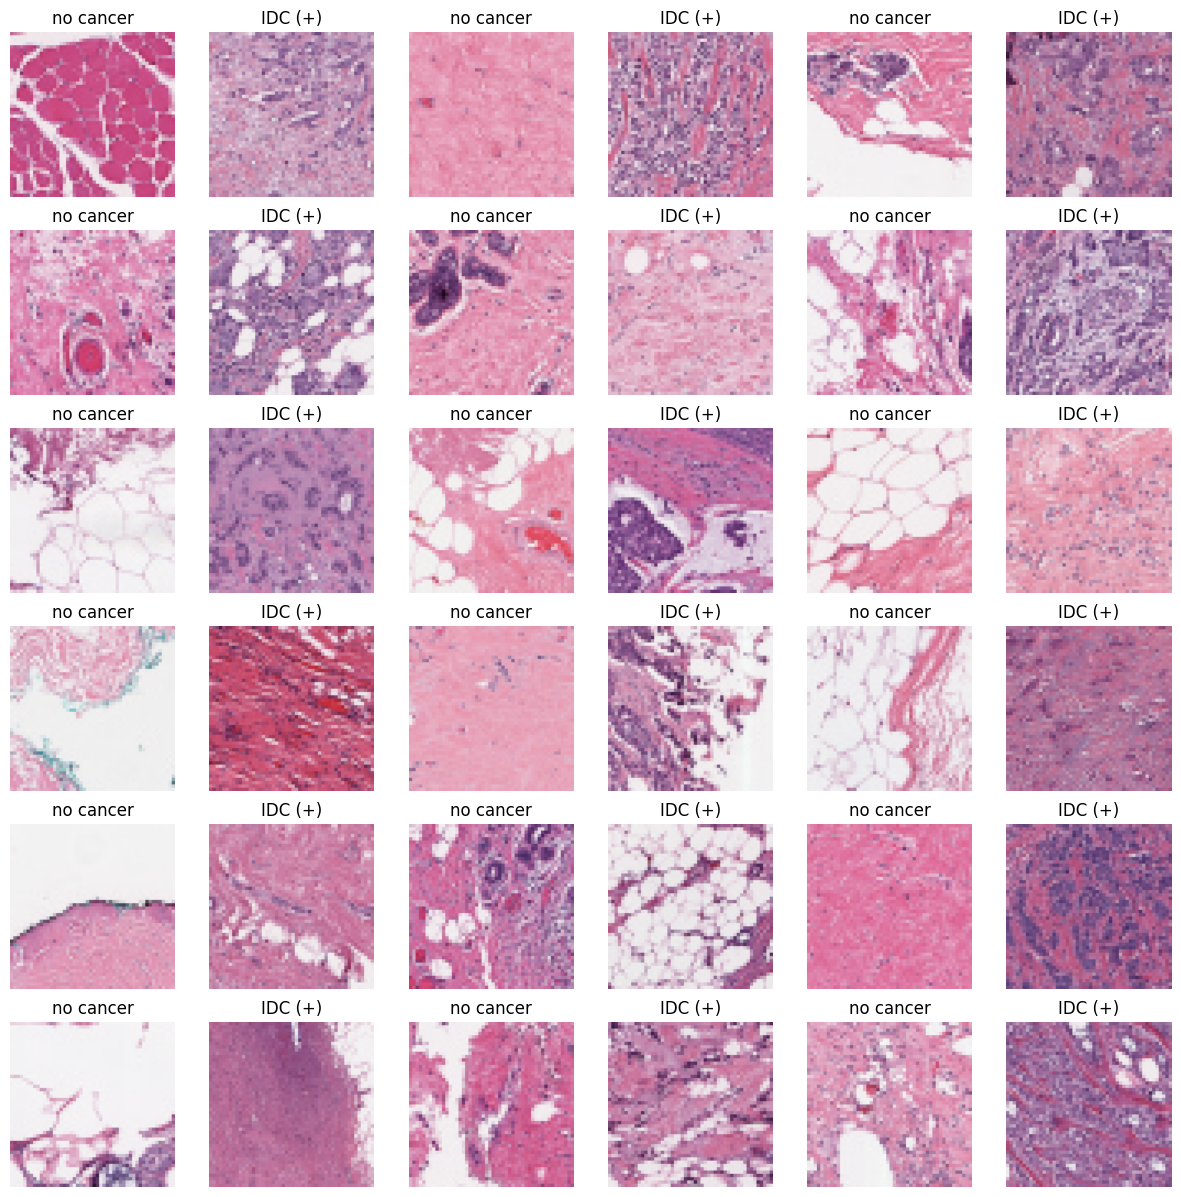

In [7]:
# Initialize two empty lists to store image file paths
N_IDC = []  # List for images without cancer
P_IDC = []  # List for images with IDC (Invasive Ductal Carcinoma)

# Loop through each image in the list "data"
for img in data:
    # Check if the image filename contains '0', it means the image doesn't have IDC
    if os.path.basename(img)[-5] == '0':
        N_IDC.append(img)
    # If it contains '1', it means the image has IDC
    elif os.path.basename(img)[-5] == '1':
        P_IDC.append(img)


# Create a new figure with a size of 15x15 inches to display the images
plt.figure(figsize=(15, 15))

# Randomly select 18 image indices from N_IDC and P_IDC lists
some_non = np.random.randint(0, len(N_IDC), 18)  # Random indices for images without cancer
some_can = np.random.randint(0, len(P_IDC), 18)  # Random indices for images with IDC

# Initialize a counter variable
s = 0

# Loop through the randomly selected indices for images without cancer
for num in some_non:
    # Load the image using Keras' image.load_img and resize it to (100, 100) pixels
    img = image.load_img((N_IDC[num]), target_size=(100, 100))
    img = image.img_to_array(img)

    # Plot the image on the subplot with 2*s+1 position in a 6x6 grid
    plt.subplot(6, 6, 2 * s + 1)
    plt.axis('off')  # Turn off axis ticks and labels
    plt.title('no cancer')  # Set the title for the subplot
    plt.imshow(img.astype('uint8'))  # Display the image as a 8-bit unsigned integer array
    s += 1  # Increment the counter

# Reset the counter variable
s = 1

# Loop through the randomly selected indices for images with IDC
for num in some_can:
    # Load the image using Keras' image.load_img and resize it to (100, 100) pixels
    img = image.load_img((P_IDC[num]), target_size=(100, 100))
    img = image.img_to_array(img)

    # Plot the image on the subplot with 2*s position in a 6x6 grid
    plt.subplot(6, 6, 2 * s)
    plt.axis('off')  # Turn off axis ticks and labels
    plt.title('IDC (+)')  # Set the title for the subplot
    plt.imshow(img.astype('uint8'))  # Display the image as a 8-bit unsigned integer array
    s += 1  # Increment the counter

# Display the figure with all the subplots
plt.show()


In [8]:
print(len(N_IDC))
print(len(P_IDC))


198738
78786


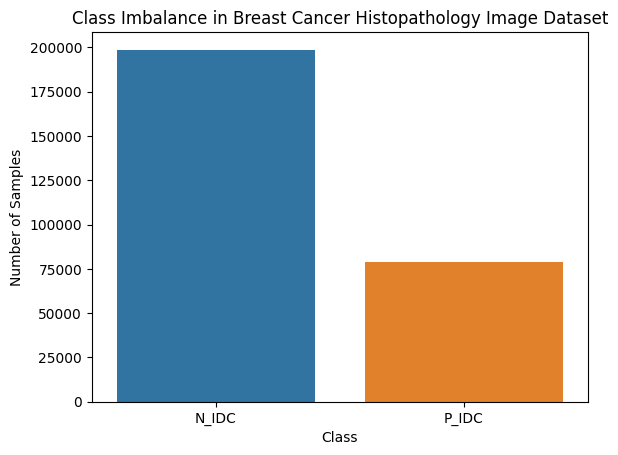

In [9]:
# Create a DataFrame for class imbalance
data = {
    'Class': ['N_IDC', 'P_IDC'],
    'Number of Samples': [len(N_IDC), len(P_IDC)]
}
df_imbalance = pd.DataFrame(data)

# Plot the class imbalance using sns.barplot
sns.barplot(data=df_imbalance, x='Class', y='Number of Samples')
plt.xlabel('Class')
plt.ylabel('Number of Samples')
plt.title('Class Imbalance in Breast Cancer Histopathology Image Dataset')
plt.show()


In [10]:
# Apply random under-sampling to balance the class distribution
rus = RandomUnderSampler(random_state=42)

# Combine the two lists for under-sampling
data_under_sampled, labels_under_sampled = rus.fit_resample(np.array(N_IDC + P_IDC).reshape(-1, 1), np.array([0] * len(N_IDC) + [1] * len(P_IDC)))



In [11]:
# Split the data into training and testing sets
X_train, X_test, Y_train, Y_test = train_test_split(data_under_sampled, labels_under_sampled, test_size=0.2, random_state=42)

# Initialize empty lists to store image data after preprocessing
X_train_images = []
X_test_images = []



In [12]:
# Preprocess the training images

for img_path in X_train:
    img = image.load_img(img_path[0], target_size=(50, 50))
    img = image.img_to_array(img)
    X_train_images.append(img)

# Preprocess the testing images

for img_path in X_test:
    img = image.load_img(img_path[0], target_size=(50, 50))
    img = image.img_to_array(img)
    X_test_images.append(img)


In [13]:
# Convert the image data lists to numpy arrays
X_train = np.array(X_train_images)
X_test = np.array(X_test_images)

In [14]:
# Encode labels to hot vectors 
Y_train_hot = to_categorical(Y_train, num_classes=2)
Y_test_hot = to_categorical(Y_test, num_classes=2)

C:\Python3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


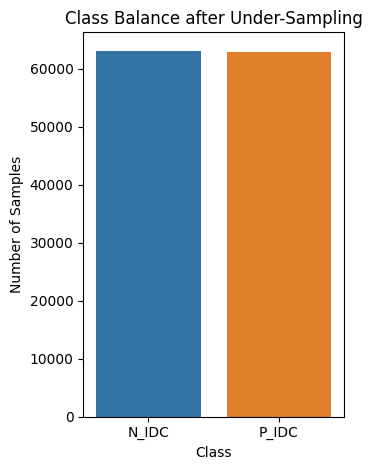

In [15]:
# Visualization: Plot class imbalance after under-sampling
df_before = pd.DataFrame()
df_before["labels"] = labels_under_sampled
lab_before = df_before['labels']
dist_before = lab_before.value_counts()

df_after = pd.DataFrame()
df_after["labels"] = Y_train
lab_after = df_after['labels']
dist_after = lab_after.value_counts()

# Plot class imbalance after under-sampling
plt.subplot(1, 2, 2)
sns.countplot(lab_after)
plt.title("Class Balance after Under-Sampling")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.xticks([0, 1], ['N_IDC', 'P_IDC'])

plt.tight_layout()
plt.show()

### Building Model and Checking accuracy

In [16]:
img_size = (50, 50)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = 2 # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
base_model = tf.keras.applications.EfficientNetV2S(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(2, activation= 'softmax')
])

model.summary()

82420632/82420632 [==============================] - 7s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetv2-s (Functiona  (None, 1280)             20331360  
 l)                                                              
                                                                 
 batch_normalization (BatchN  (None, 1280)             5120      
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 256)               327936    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                         

In [18]:
# Create a function for the model checkpoint callback
def mod_checkpoint_callback():
    """
    Saving our model

    Returns:
        None: Saving a checkpoint of the model.
    """
    trained_model = ModelCheckpoint(filepath='model.h5',    # result file name
                                    save_weights_only=False,  # Save all training results/params.
                                    monitor='val_accuracy',    # Check our model accuracy if it's a step forward.
                                    mode='auto',              # Enable auto save.
                                    save_best_only=True,      # Save the model only if the accuracy improves.
                                    verbose=1)
    return trained_model

# Monitoring the training process in each epoch.
early_stopping_monitor = EarlyStopping(patience=100, monitor='val_accuracy')

model_checkpoint_callback = mod_checkpoint_callback()

datagen = ImageDataGenerator(zoom_range=0.2, horizontal_flip=True, shear_range=0.2)
datagen.fit(X_train)

# Compile the model with Adamax optimizer and binary crossentropy loss
model.compile(optimizer=Adamax(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(datagen.flow(X_train, Y_train_hot), validation_data=(X_test, Y_test_hot), epochs=20, batch_size=35)

Epoch 1/20
3940/3940 [==============================] - 2227s 563ms/step - loss: 2.5242 - accuracy: 0.8111 - val_loss: 0.9928 - val_accuracy: 0.8477
Epoch 2/20
3940/3940 [==============================] - 2199s 558ms/step - loss: 0.7188 - accuracy: 0.8449 - val_loss: 0.5244 - val_accuracy: 0.8692
Epoch 3/20
3940/3940 [==============================] - 2189s 556ms/step - loss: 0.4852 - accuracy: 0.8593 - val_loss: 0.4147 - val_accuracy: 0.8748
Epoch 4/20
3940/3940 [==============================] - 2190s 556ms/step - loss: 0.4148 - accuracy: 0.8689 - val_loss: 0.3765 - val_accuracy: 0.8778
Epoch 5/20
3940/3940 [==============================] - 2179s 553ms/step - loss: 0.3796 - accuracy: 0.8756 - val_loss: 0.3543 - val_accuracy: 0.8832
Epoch 6/20
3940/3940 [==============================] - 2170s 551ms/step - loss: 0.3578 - accuracy: 0.8816 - val_loss: 0.3386 - val_accuracy: 0.8859
Epoch 7/20
3940/3940 [==============================] - 2160s 548ms/step - loss: 0.3416 - accuracy: 0.8865

In [19]:
model.save('model.h5')

In [20]:
# Convert the model's predictions from one-hot encoded format to integer labels
Y_pred = model.predict(X_test).argmax(axis=1)

# Convert one-hot encoded ground truth labels to integer labels
Y_test_labels = Y_test_hot.argmax(axis=1)

# Create a list of class labels
class_labels = ['IDC(-)', 'IDC(+)']

# Calculate precision, recall, F1-score, and support for each class
report = classification_report(Y_test_labels, Y_pred, target_names=class_labels)

print("Classification Report:")
print(report)

985/985 [==============================] - 106s 106ms/step
Classification Report:
              precision    recall  f1-score   support

      IDC(-)       0.90      0.88      0.89     15632
      IDC(+)       0.88      0.90      0.89     15883

    accuracy                           0.89     31515
   macro avg       0.89      0.89      0.89     31515
weighted avg       0.89      0.89      0.89     31515



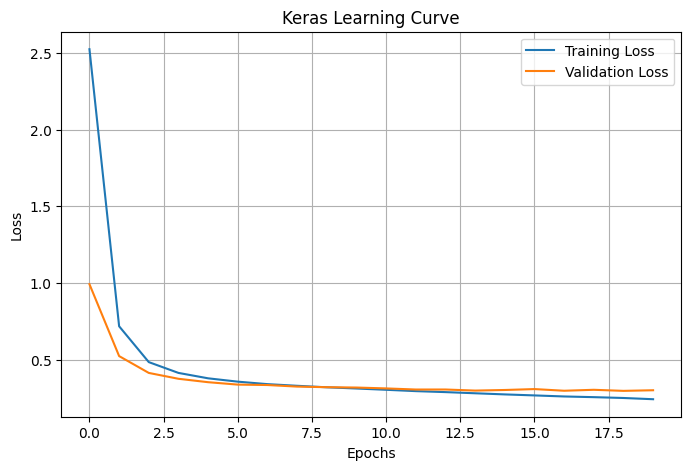

In [21]:
# Define the functions for learning curve plots and confusion matrix plot
def plotKerasLearningCurve():
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Keras Learning Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

# Plot Keras Learning Curve
plotKerasLearningCurve()
plt.show()



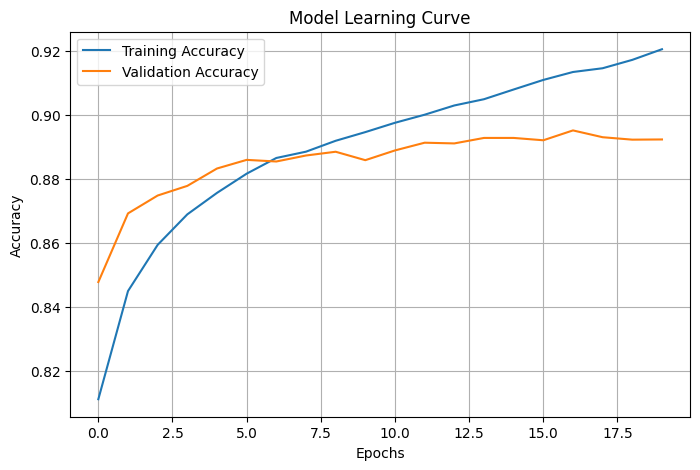

In [22]:
def plot_learning_curve(history):
    plt.figure(figsize=(8, 5))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Learning Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

# Plot Model Learning Curve
plot_learning_curve(history)
plt.show()

985/985 [==============================] - 112s 113ms/step


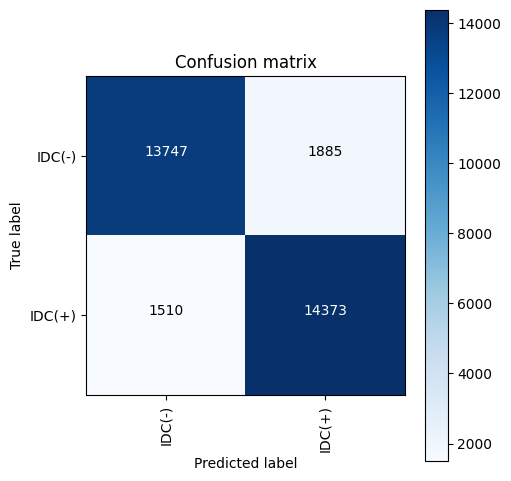

In [23]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

y_pred = model.predict(X_test)
    
Y_pred_classes = np.argmax(y_pred,axis=1) 
Y_true = np.argmax(Y_test_hot,axis=1) 
    
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes=class_labels) 
plt.show()